# MNIST RNN

This single-GRU-based model learns to generate greyscale "images" which are just a bunch of pixels in a single line.
Specifically, it learns to generate images which steadily increase in brightness as they move left-to-right.

In [1]:
import random
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

The dataset is very easy to generate, and we can easily preview the first few lines.

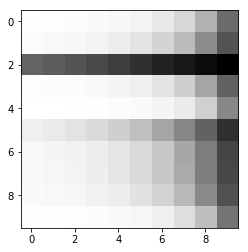

In [176]:
dataset = []
for _ in range(1000):
    principal = random.random() / 2 + 0.5
    rate = random.random() + 1
    maximum = principal * rate ** 10
    dataset.append([(principal * rate ** i) / maximum for i in range(10)])
dataset = np.array(dataset)
dataset /= dataset.max()

plt.imshow(dataset[:10, :], cmap='Greys');

Now, we can create the GRU, which reads a sequence of values from left to right to determine the value of the next pixel.

In [233]:
%%time

hidden_size = 8
gru = nn.GRU(input_size=1, hidden_size=hidden_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(gru.parameters(), lr=0.0001)

losses = []

batch_size = 100
n_epochs = 400

for epoch in range(n_epochs):
    if epoch % 10 == 0:
        print('Epoch', epoch)

    np.random.shuffle(dataset)
    batches = []
    batch = []
    for line in dataset:
        batch.append(line)
        if len(batch) == batch_size:
            batches.append(batch)
            batch = []
    batches = np.array(batches).reshape(-1, batch_size, 10, 1)
    batches = np.swapaxes(batches, 1, 2)

    for batch in batches:
        x = batch[:, :-1]
        y = np.roll(batch, -1)[:, :-1]
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        x, y = x.float(), y.float()
        gru.zero_grad()
        gru_out, _ = gru(x)
        loss = criterion(gru_out, y)
        loss.backward()
        optimizer.step()
        losses.append(loss)

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 160
Epoch 170
Epoch 180
Epoch 190
Epoch 200
Epoch 210
Epoch 220
Epoch 230
Epoch 240
Epoch 250
Epoch 260
Epoch 270
Epoch 280
Epoch 290
Epoch 300
Epoch 310
Epoch 320
Epoch 330
Epoch 340
Epoch 350
Epoch 360
Epoch 370
Epoch 380
Epoch 390
CPU times: user 29.9 s, sys: 401 ms, total: 30.3 s
Wall time: 30.3 s


In [234]:
reconstruction

array([[0.2567085 , 0.17452723, 0.18564579, 0.1841686 , 0.18436535,
        0.18433918, 0.18434264, 0.18434215, 0.18434227, 0.18434222],
       [0.00933397, 0.20657782, 0.18136458, 0.18473843, 0.18428952,
        0.18434922, 0.18434131, 0.18434235, 0.18434224, 0.18434222],
       [0.01534326, 0.20585003, 0.18146259, 0.18472539, 0.18429121,
        0.18434903, 0.18434134, 0.18434235, 0.18434224, 0.18434222],
       [0.00355863, 0.2072749 , 0.18127072, 0.18475085, 0.18428782,
        0.1843495 , 0.18434128, 0.18434235, 0.18434224, 0.18434222],
       [0.32010233, 0.16563705, 0.18682075, 0.184012  , 0.18438622,
        0.1843364 , 0.18434304, 0.18434212, 0.18434227, 0.18434222],
       [0.00113957, 0.20756617, 0.18123144, 0.1847561 , 0.18428713,
        0.18434957, 0.18434125, 0.18434235, 0.18434224, 0.18434222],
       [0.00290198, 0.20735398, 0.18126   , 0.18475232, 0.18428762,
        0.1843495 , 0.18434128, 0.18434235, 0.18434224, 0.18434222],
       [0.01021212, 0.20647165, 0.1813788

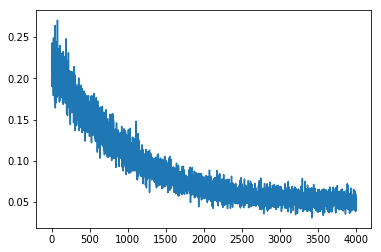

In [235]:
plt.plot(losses)

In [236]:
initial_pixels = torch.from_numpy(dataset[:10, 0]).reshape(1, 10, 1).float()
reconstruction = initial_pixels
column = initial_pixels
for _ in range(9):
    column = gru(column)[0]
    reconstruction = np.concatenate([reconstruction, column.detach().numpy()])

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [239]:
reconstruction.shape

torch.Size([1, 10, 1])

In [226]:
reconstruction = reconstruction.reshape(10, 10).T

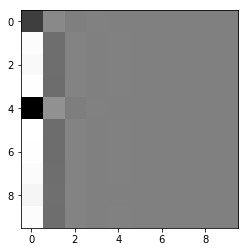

In [227]:
plt.imshow(reconstruction, cmap='Greys')